**This notebook explores two examples of learners that are trying to explore the logical relation between strings, as defined by an Ehrenfeucht–Fraisse game logic.**

**See Ehrenfeucht–Fraisse_game notebook for more information**

In [1]:
import sys
sys.path.append("..")
from src.ef_game import *
from src.utils import *
from src.models import *

# EF Game and Labels

### This defines the ground truth: the logical structure to explore

**Labels are 1 for strings that are similar, 0 if not (according to the EF-game: see related notebook)**

In [2]:

bit_strings = ['{:04b}'.format(i) for i in range(16)]
labels = ef_equivalence_labels(bit_strings,k=2,max_states=None)


# Classifier vs Contrastive Learners

In [3]:

# Dataset: all pairwise string pairs and labels
all_strings = ['{:04b}'.format(i) for i in range(16)]
pairs = []
for (s1, s2), label in labels.items():
    pairs.append((s1, s2, label))

random.shuffle(pairs)

## Classifier

**Learns to predict properties (e.g., parity) of strings from labeled examples.**


In [4]:
seed = 42
set_seed(seed)
model = EmbeddingMLP(input_dim=4, embed_dim=2,num_neurons=4,embed_hidden=2)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
loss_fn = nn.BCELoss()

# Training
for epoch in range(5000):
    total_loss = 0.0
    for x1, x2, y in batch(pairs, batch_size=16):
        pred = model(x1, x2)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 1000 == 0:
        print(f"Epoch {epoch} loss: {total_loss:.4f}")


Epoch 0 loss: 11.2369
Epoch 1000 loss: 10.5126
Epoch 2000 loss: 10.5136
Epoch 3000 loss: 10.5134
Epoch 4000 loss: 10.5125


In [5]:
# get embeddings
with torch.no_grad(): 
    z_map = {s: model.embed_hidden(string_to_tensor(s).unsqueeze(0))[1].squeeze().numpy() for s in all_strings}

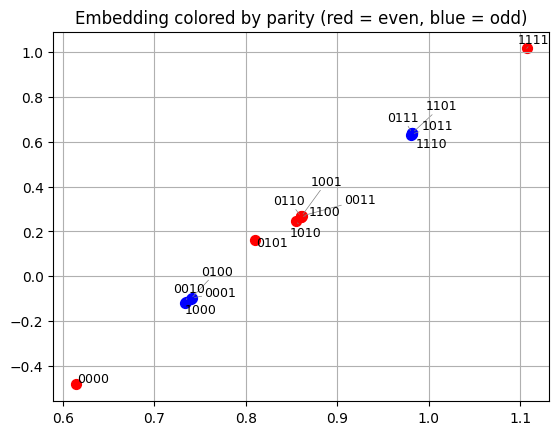

In [6]:
def parity(s): return sum(int(ch) for ch in s) % 2

colors = ['red' if parity(s) == 0 else 'blue' for s in z_map.keys()]

texts = []
for s, z in z_map.items():
    plt.scatter(z[0], z[1], color=colors.pop(0), s=50)
    # plt.text(z[0] + 0.01, z[1] + 0.01, s, fontsize=9)
    texts.append(plt.text(z[0], z[1], s, fontsize=9))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

plt.title("Embedding colored by parity (red = even, blue = odd)")
plt.grid(True)
plt.show()


In [7]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

activations = []
parities = []
hamming_weights = []
all_strings = ['{:04b}'.format(i) for i in range(16)]

for s in all_strings:
    x = string_to_tensor(s).unsqueeze(0)
    h, _ = model.embed_hidden(x)
    activations.append(h.squeeze().detach().numpy())
    parities.append(sum(int(c) for c in s) % 2)
    hamming_weights.append(sum(int(c) for c in s))

activations = np.array(activations)  # shape (16, 8)


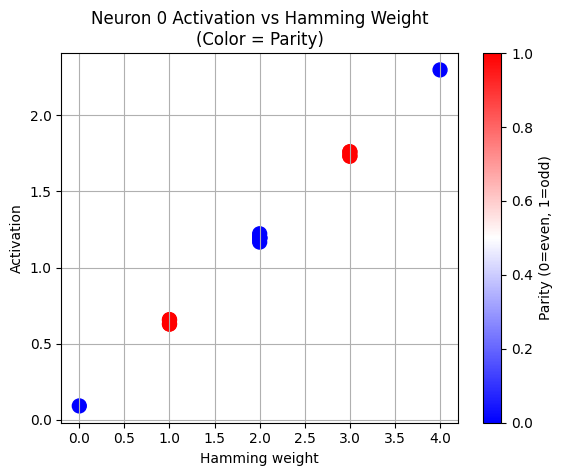

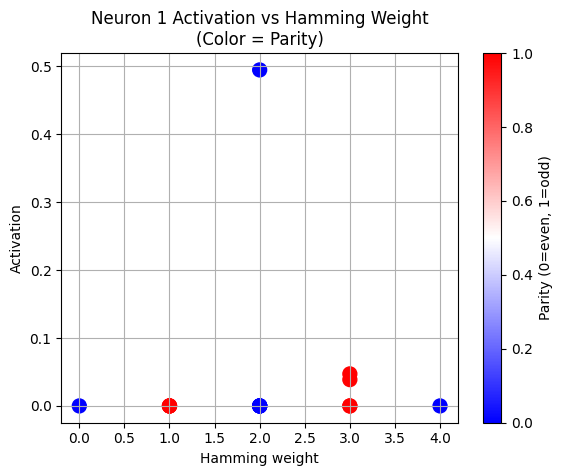

In [8]:
import matplotlib.pyplot as plt

for i in range(activations.shape[1]):
    plt.figure()
    plt.scatter(hamming_weights, activations[:, i], c=parities, cmap='bwr', s=100)
    plt.title(f"Neuron {i} Activation vs Hamming Weight\n(Color = Parity)")
    plt.xlabel("Hamming weight")
    plt.ylabel("Activation")
    plt.colorbar(label="Parity (0=even, 1=odd)")
    plt.grid(True)
    plt.show()


# Agent Explorer Contrastive Learning

**Learns an embedding space where similar strings are close and dissimilar ones are far.**

In [9]:
bit_strings = ['{:04b}'.format(i) for i in range(16)]
G = build_ef_graph(bit_strings, k=2)


Generate some random sequences - only logically equivalent strings can be adjiacent, except jumps with a certain probability


In [11]:
# Suppose G is your EF graph (e.g., parity-aware with 4-bit strings)
agent = Agent(G)
teleport_prob = 0.3  # chance to jump to a new component between sequences

sequences = []
for _ in range(1000):
    if random.random() < teleport_prob:
        agent.reset()  # teleport to another component (e.g. from even to odd)
    seq = agent.sample_sequence(length=25)
    sequences.append(seq)

# Quick check
for seq in sequences[:5]:
    print(seq)


['0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000']
['0100', '1101', '0111', '0001', '1101', '1000', '1101', '0001', '1000', '0001', '1011', '0111', '1110', '1011', '0111', '1101', '0100', '1110', '0010', '0001', '1101', '0100', '0111', '0001', '0100']
['1110', '1000', '1110', '0111', '0010', '0111', '0100', '0010', '1110', '0111', '1110', '1101', '1110', '0010', '1011', '1110', '0100', '1101', '1110', '0100', '0010', '1000', '1011', '0111', '1110']
['0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000']
['0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000', '00

In [13]:
# positive examples ("these strings are similar")
positive_pairs = extract_positive_pairs(sequences)


In [14]:
# Set of all positive pairs
positive_set = set(frozenset((a, b)) for a, b in positive_pairs)

# All possible pairs
# All unique unordered string pairs
all_pairs = [
    (a, b) for a, b in itertools.combinations(bit_strings, 2)
]

# Filter out those that are in positive_set
negative_pairs = [
    (a, b) for a, b in all_pairs if frozenset((a, b)) not in positive_set
]

In [16]:
import torch.optim as optim

set_seed(7)


# Training loop

batch_size = 32
num_negatives = 4

model = Embedder()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(2000):
    batch = random.sample(positive_pairs, k=batch_size)

    xa = torch.stack([string_to_tensor(a) for a, b in batch])
    xb = torch.stack([string_to_tensor(b) for a, b in batch])

    # Sample negatives for each anchor
    x_neg_list = []
    for a, _ in batch:
        # Pick N strings NOT equivalent to a
        negs = [b for b in bit_strings if frozenset((a, b)) not in positive_set and b != a]
        neg_sample = random.sample(negs, k=num_negatives)
        x_neg = torch.stack([string_to_tensor(b) for b in neg_sample])  # [N, D]
        x_neg_list.append(x_neg)

    x_neg_tensor = torch.stack(x_neg_list)  # [B, N, D]

    # Forward pass
    z_anchor = model(xa)         # [B, D]
    z_positive = model(xb)       # [B, D]
    z_negatives = model(x_neg_tensor.view(-1, 4))  # flatten to [B*N, D]
    z_negatives = z_negatives.view(batch_size, num_negatives, -1)  # reshape to [B, N, D]

    loss = info_nce_loss(z_anchor, z_positive, z_negatives)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")





Epoch 0, Loss: 1.8522
Epoch 200, Loss: 0.1208
Epoch 400, Loss: 0.1060
Epoch 600, Loss: 0.1160
Epoch 800, Loss: 0.1049
Epoch 1000, Loss: 0.1115
Epoch 1200, Loss: 0.1192
Epoch 1400, Loss: 0.1277
Epoch 1600, Loss: 0.1103
Epoch 1800, Loss: 0.1117


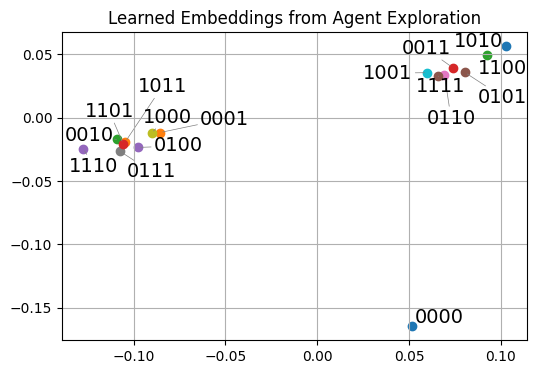

In [17]:


with torch.no_grad():
    z_map = {s: model(string_to_tensor(s).unsqueeze(0)).squeeze().numpy() for s in bit_strings}

# Create a larger figure
plt.figure(figsize=(6, 4))

texts=[]
for s, z in z_map.items():
    plt.scatter(z[0], z[1]);
    t = plt.text(z[0], z[1], s, fontsize=14);
    texts.append(t);

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

plt.title("Learned Embeddings from Agent Exploration")
plt.grid(True)
plt.show()


Training with hidden size: 2
Epoch 0, Loss: 2.1986
Epoch 200, Loss: 2.1903
Epoch 400, Loss: 2.1915
Epoch 600, Loss: 2.1811
Epoch 800, Loss: 2.1793
Epoch 1000, Loss: 2.1685
Epoch 1200, Loss: 2.1653
Epoch 1400, Loss: 2.1429
Epoch 1600, Loss: 2.1334
Epoch 1800, Loss: 2.0921

Training with hidden size: 8
Epoch 0, Loss: 2.1874
Epoch 200, Loss: 2.1799
Epoch 400, Loss: 2.1868
Epoch 600, Loss: 2.1611
Epoch 800, Loss: 2.1023
Epoch 1000, Loss: 2.0491
Epoch 1200, Loss: 1.9773
Epoch 1400, Loss: 2.0126
Epoch 1600, Loss: 1.9580
Epoch 1800, Loss: 1.8997

Training with hidden size: 32
Epoch 0, Loss: 2.2492
Epoch 200, Loss: 2.1929
Epoch 400, Loss: 2.1590
Epoch 600, Loss: 1.9750
Epoch 800, Loss: 1.9359
Epoch 1000, Loss: 1.7751
Epoch 1200, Loss: 1.5396
Epoch 1400, Loss: 1.1973
Epoch 1600, Loss: 0.6353
Epoch 1800, Loss: 0.4317


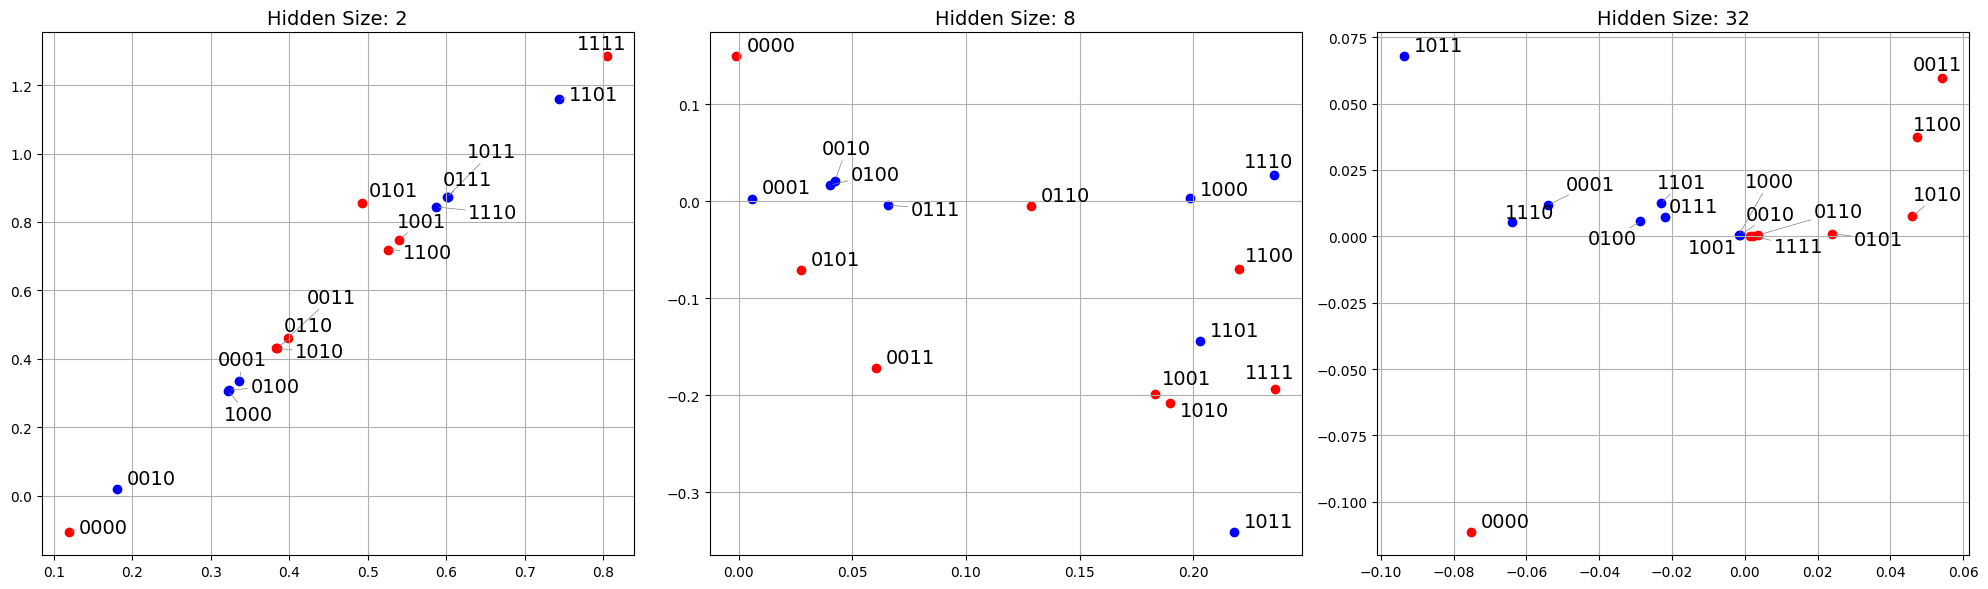

In [19]:
def parity(s): return sum(int(ch) for ch in s) % 2

# Loop over different hidden layer sizes
hidden_sizes = [ 2,8,32]
results = []  # Store embeddings and hidden sizes

for hidden_size in hidden_sizes:
    print(f"\n{'='*50}")
    print(f"Training with hidden size: {hidden_size}")
    print(f"{'='*50}")
    
    set_seed(42)
    
    # Define model with current hidden size

    
    # Training loop
    batch_size = 64
    num_negatives = 8
    model = EmbedderVariable(hidden_dim=hidden_size)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    for epoch in range(2000):
        batch = random.sample(positive_pairs, k=batch_size)
        xa = torch.stack([string_to_tensor(a) for a, b in batch])
        xb = torch.stack([string_to_tensor(b) for a, b in batch])
        
        # Sample negatives for each anchor
        x_neg_list = []
        for a, _ in batch:
            negs = [b for b in bit_strings if frozenset((a, b)) not in positive_set and b != a]
            neg_sample = random.sample(negs, k=num_negatives)
            x_neg = torch.stack([string_to_tensor(b) for b in neg_sample])
            x_neg_list.append(x_neg)
        x_neg_tensor = torch.stack(x_neg_list)
        
        # Forward pass
        z_anchor = model(xa)
        z_positive = model(xb)
        z_negatives = model(x_neg_tensor.view(-1, 4))
        z_negatives = z_negatives.view(batch_size, num_negatives, -1)
        
        loss = info_nce_loss(z_anchor, z_positive, z_negatives)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 200 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    
    # Generate and store embeddings
    with torch.no_grad():
        z_map = {s: model(string_to_tensor(s).unsqueeze(0)).squeeze().numpy() for s in bit_strings}
    
    results.append((hidden_size, z_map))

# Create grid of figures
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes = axes.flatten()
colors = ['red' if parity(s) == 0 else 'blue' for s in z_map.keys()]

for idx, (hidden_size, z_map) in enumerate(results):
    ax = axes[idx]
    texts = []
    
    for (s, z), color in zip(z_map.items(), colors):        
        if s != '001110':
            ax.scatter(z[0], z[1],color=color)
            texts.append(ax.text(z[0], z[1], s, fontsize=14))
    
    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
    ax.set_title(f"Hidden Size: {hidden_size}", fontsize=14)
    ax.grid(True)

plt.tight_layout()
plt.savefig('embedding_comparison.png', dpi=150, bbox_inches='tight')
plt.show()